In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import show_images
from functions import match_descriptors, get_good_matches, ransac_homography, compute_homography, warp_images

In [15]:
import functions as f

In [2]:
cuadro0 = cv2.imread('img/cuadro_0.jpg', cv2.IMREAD_GRAYSCALE) # --> source image 
cuadro1 = cv2.imread('img/cuadro_1.jpg', cv2.IMREAD_GRAYSCALE)  # --> destination image 1  
cuadro2 = cv2.imread('img/cuadro_2.jpg', cv2.IMREAD_GRAYSCALE) # --> destination image  2

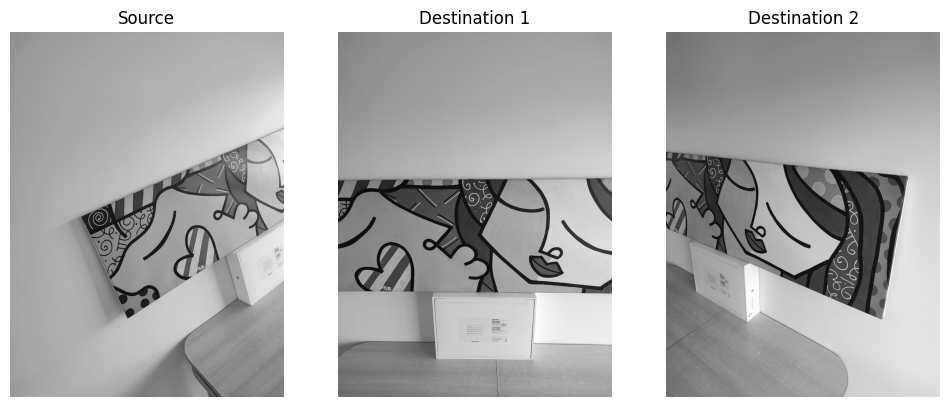

In [3]:
# Display images
show_images([
    cuadro0, cuadro1, cuadro2
], ["Source", "Destination 1", "Destination 2"])

In [4]:
# Check image sizes
print('Source Image Size:', cuadro0.shape)
print('Destination Image 1 Size:', cuadro1.shape)
print('Destination Image 2 Size:', cuadro2.shape)

Source Image Size: (4096, 3072)
Destination Image 1 Size: (4096, 3072)
Destination Image 2 Size: (4096, 3072)


In [5]:
# Busqueda de keypoints y descriptores
algo = cv2.SIFT_create()
kp0, des0 = algo.detectAndCompute(cuadro0, None)
kp1, des1 = algo.detectAndCompute(cuadro1, None)
kp2, des2 = algo.detectAndCompute(cuadro2, None)

In [8]:
# Verificamos como es uno de los keypoints detectados:
print("keypoint 0:", kp0[0])
keypoint_0 = kp0[0]
print("x, y:", keypoint_0.pt)
print("size:", keypoint_0.size)
print("octave:", keypoint_0.octave)
print("angle:", keypoint_0.angle)
print("response:", keypoint_0.response)

keypoint 0: < cv2.KeyPoint 0000027EA5348C90>
x, y: (316.4096984863281, 3418.5146484375)
size: 2.1539814472198486
octave: 13173247
angle: 190.819580078125
response: 0.013478882610797882


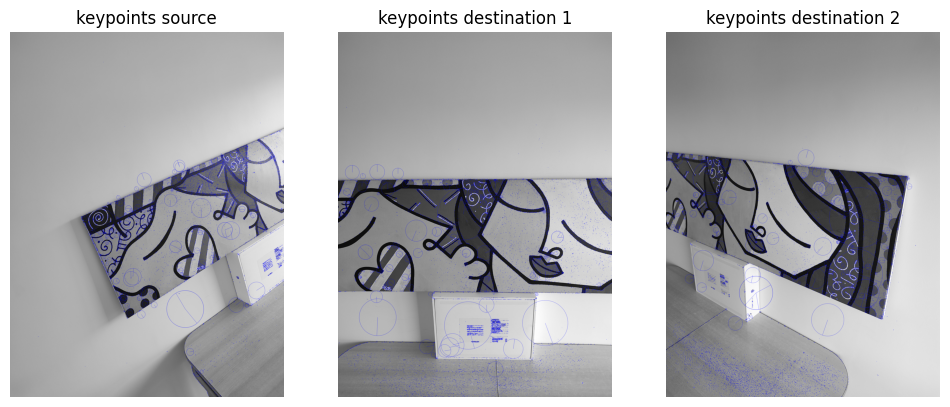

In [11]:
kp_cuadro0 = cv2.cvtColor(cuadro0, cv2.COLOR_GRAY2BGR)
kp_cuadro1 = cv2.cvtColor(cuadro1, cv2.COLOR_GRAY2BGR)
kp_cuadro2 = cv2.cvtColor(cuadro2, cv2.COLOR_GRAY2BGR)

# Display keypoints
kp_cuadro0 = cv2.drawKeypoints(cuadro0, kp0, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro1 = cv2.drawKeypoints(cuadro1, kp1, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro2 = cv2.drawKeypoints(cuadro2, kp2, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
show_images([
    kp_cuadro0, kp_cuadro1, kp_cuadro2
], ["keypoints source", "keypoints destination 1", "keypoints destination 2"])

In [13]:
print("Cantidad de keypoints detectados: ", len(kp0), ", ", len(kp1), ", ", len(kp2))

Cantidad de keypoints detectados:  13710 ,  15251 ,  14064


In [21]:
def anms(keypoints, N):
    """
    Applies Adaptive Non-Maximal Suppression (ANMS) to select the N most relevant keypoints.
    
    Args:
        keypoints (list): List of detected keypoints.
        responses (list): List of responses (strengths) for each keypoint.
        N (int): Number of keypoints to retain after ANMS.

    Returns:
        List of retained keypoints after applying ANMS.
    """
    if len(keypoints) == 0:
        return []
    
    # First sort the keypoints by their response (strength) in descending order
    keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)

    # Convert keypoints and responses to arrays
    kp_coords = np.array([kp.pt for kp in keypoints])
    kp_responses = np.array([kp.response for kp in keypoints])

    # Initialize the suppression radius with a large value
    radii = np.full(len(keypoints), np.inf)

    # Loop over each keypoint and calculate the suppression radius
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if kp_responses[j] > kp_responses[i]:  # If kp j has a stronger response
                distance = np.linalg.norm(kp_coords[i] - kp_coords[j])  # Euclidean distance
                if distance < radii[i]:  # Update the minimum radius
                    radii[i] = distance

    # Sort keypoints by their radius in descending order
    sorted_indices = np.argsort(radii)[::-1] # [::-1] reverses the array to descending order 
    selected_indices = sorted_indices[:N]  # Select the top N keypoints with the largest radius

    # Return the selected keypoints
    selected_keypoints = [keypoints[i] for i in selected_indices]
    return selected_keypoints

In [27]:
# Ordenamos los keypoints por su respuesta
kp0 = sorted(kp0, key=lambda x: x.response, reverse=True)
kp1 = sorted(kp1, key=lambda x: x.response, reverse=True)
kp2 = sorted(kp2, key=lambda x: x.response, reverse=True)

In [25]:
# Implementamos Adaptive Non-Maximal Suppression (ANMS)
anms_kp0 = anms(kp0[:5000], 1000)

In [28]:
# Implementamos Adaptive Non-Maximal Suppression (ANMS)
anms_kp1 = anms(kp1[:5000], 1000)
anms_kp2 = anms(kp2[:5000], 1000)

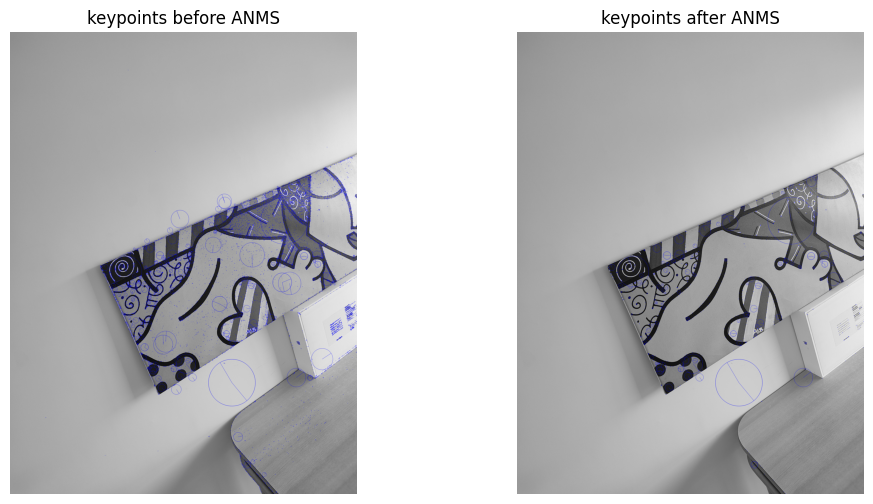

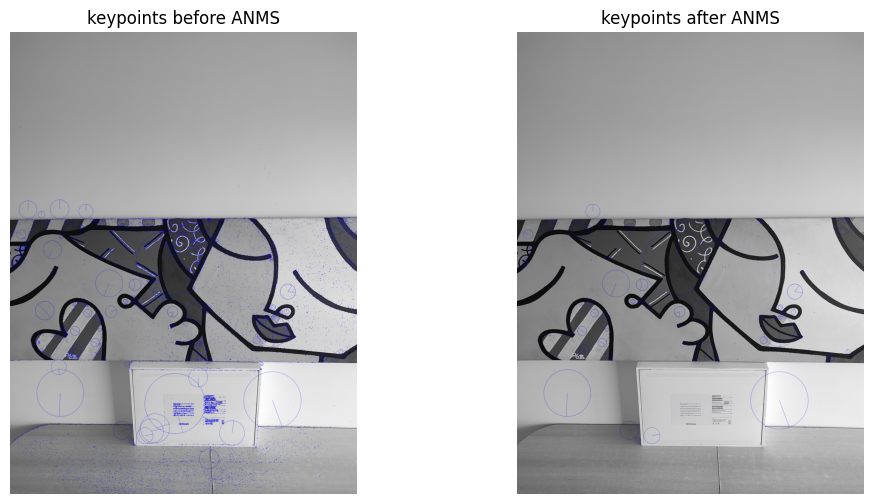

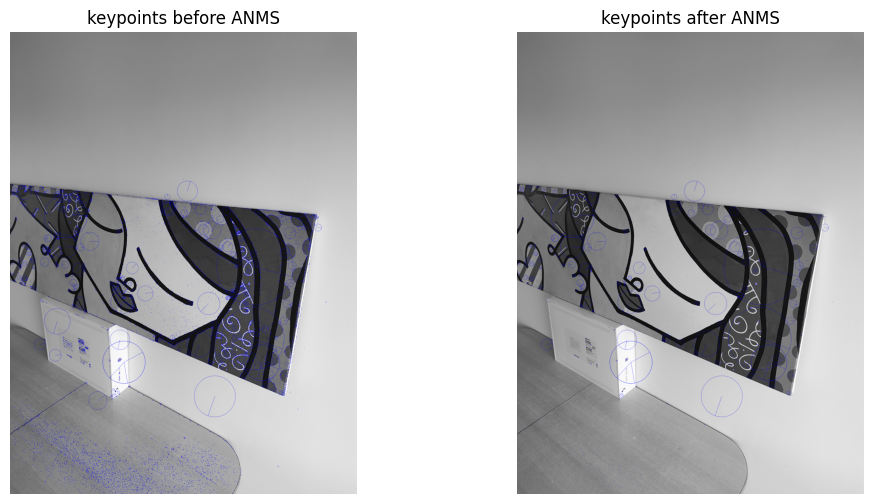

In [29]:
anms_kp_cuadro0 = cv2.cvtColor(cuadro0, cv2.COLOR_GRAY2BGR)
anms_kp_cuadro1 = cv2.cvtColor(cuadro1, cv2.COLOR_GRAY2BGR)
anms_kp_cuadro2 = cv2.cvtColor(cuadro2, cv2.COLOR_GRAY2BGR)

# Display keypoints
anms_kp_cuadro0 = cv2.drawKeypoints(cuadro0, kp0, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
anms_kp_cuadro1 = cv2.drawKeypoints(cuadro1, kp1, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
anms_kp_cuadro2 = cv2.drawKeypoints(cuadro2, kp2, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
show_images([kp_cuadro0, anms_kp_cuadro0], ["keypoints before ANMS", "keypoints after ANMS"])
show_images([kp_cuadro1, anms_kp_cuadro1], ["keypoints before ANMS", "keypoints after ANMS"])
show_images([kp_cuadro2, anms_kp_cuadro2], ["keypoints before ANMS", "keypoints after ANMS"])

In [30]:
print("Cantidad de keypoints detectados: ", len(kp0), ", ", len(kp1), ", ", len(kp2))

Cantidad de keypoints detectados:  1000 ,  1000 ,  1000


In [46]:
# Obtenemos los descriptores correspondientes a los keypoints seleccionados
des0 = algo.compute(anms_kp_cuadro0, anms_kp0)[1]
des1 = algo.compute(anms_kp_cuadro1, anms_kp1)[1]
des2 = algo.compute(anms_kp_cuadro2, anms_kp2)[1]

In [47]:
print("Cantidad de descriptores obtenidos: ", len(des0), ", ", len(des1), ", ", len(des2))

Cantidad de descriptores obtenidos:  1000 ,  1000 ,  1000


In [48]:
matches01, matchesMask01 = match_descriptors(des0, des1)
matches12, matchesMask12 = match_descriptors(des1, des2)

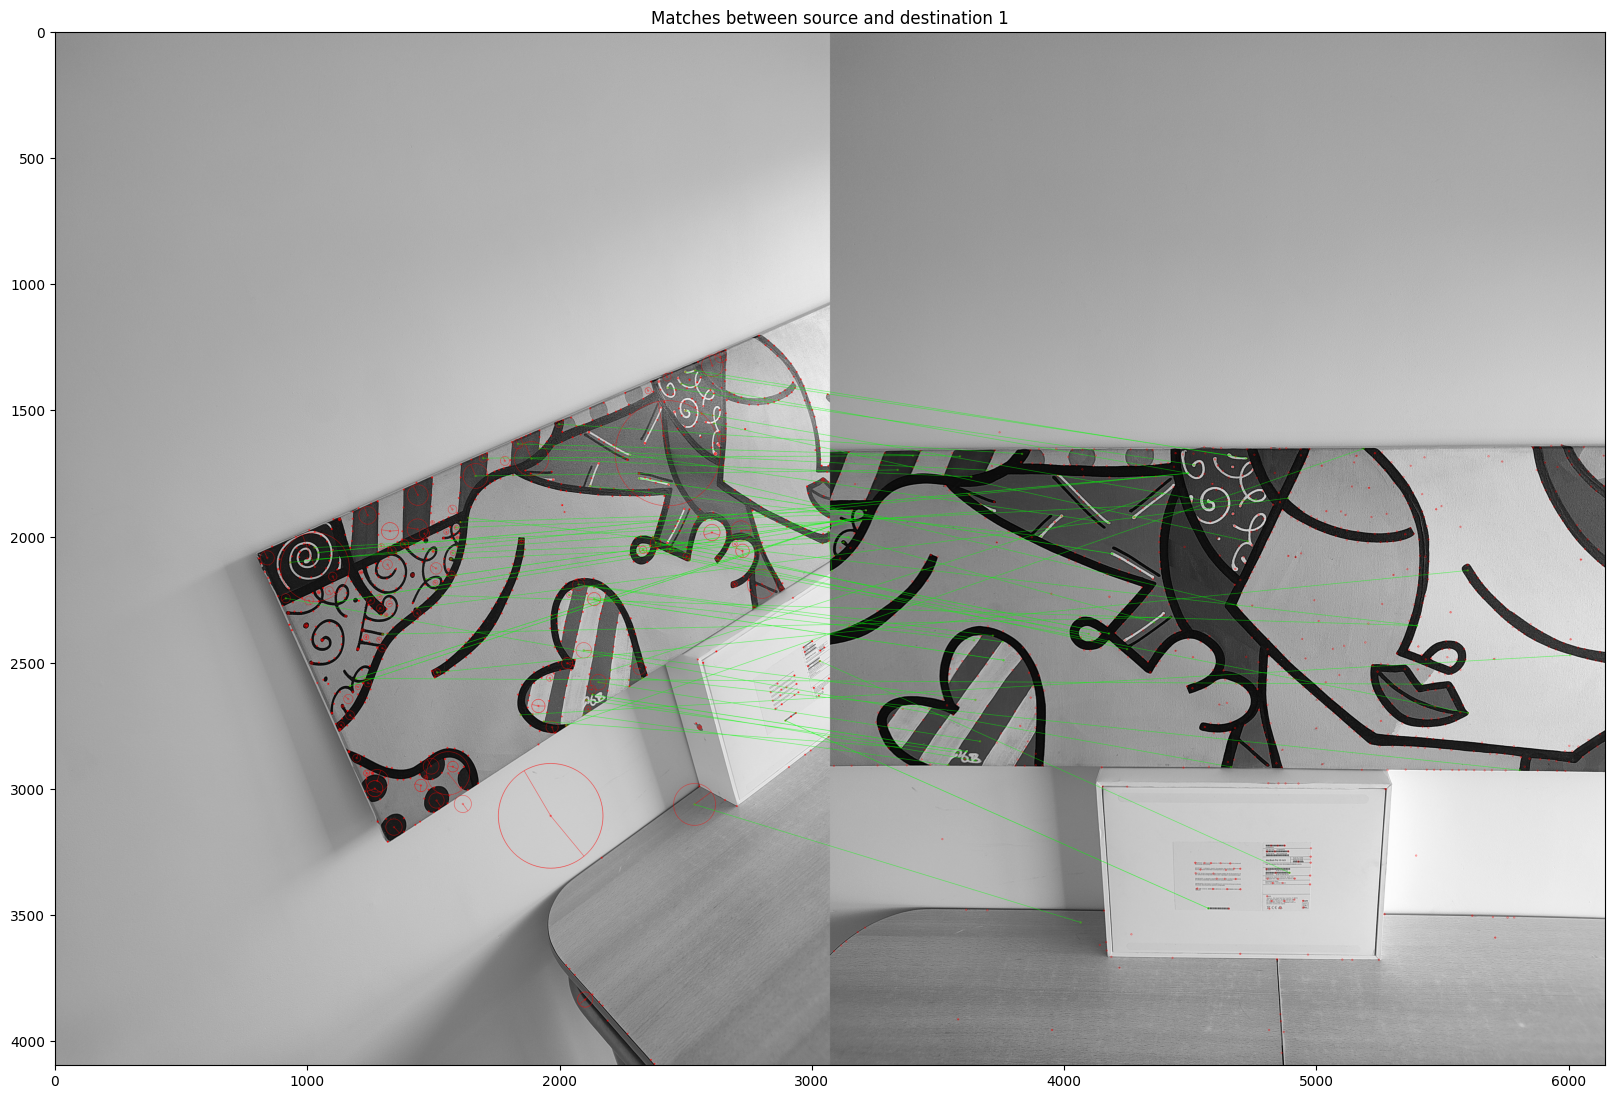

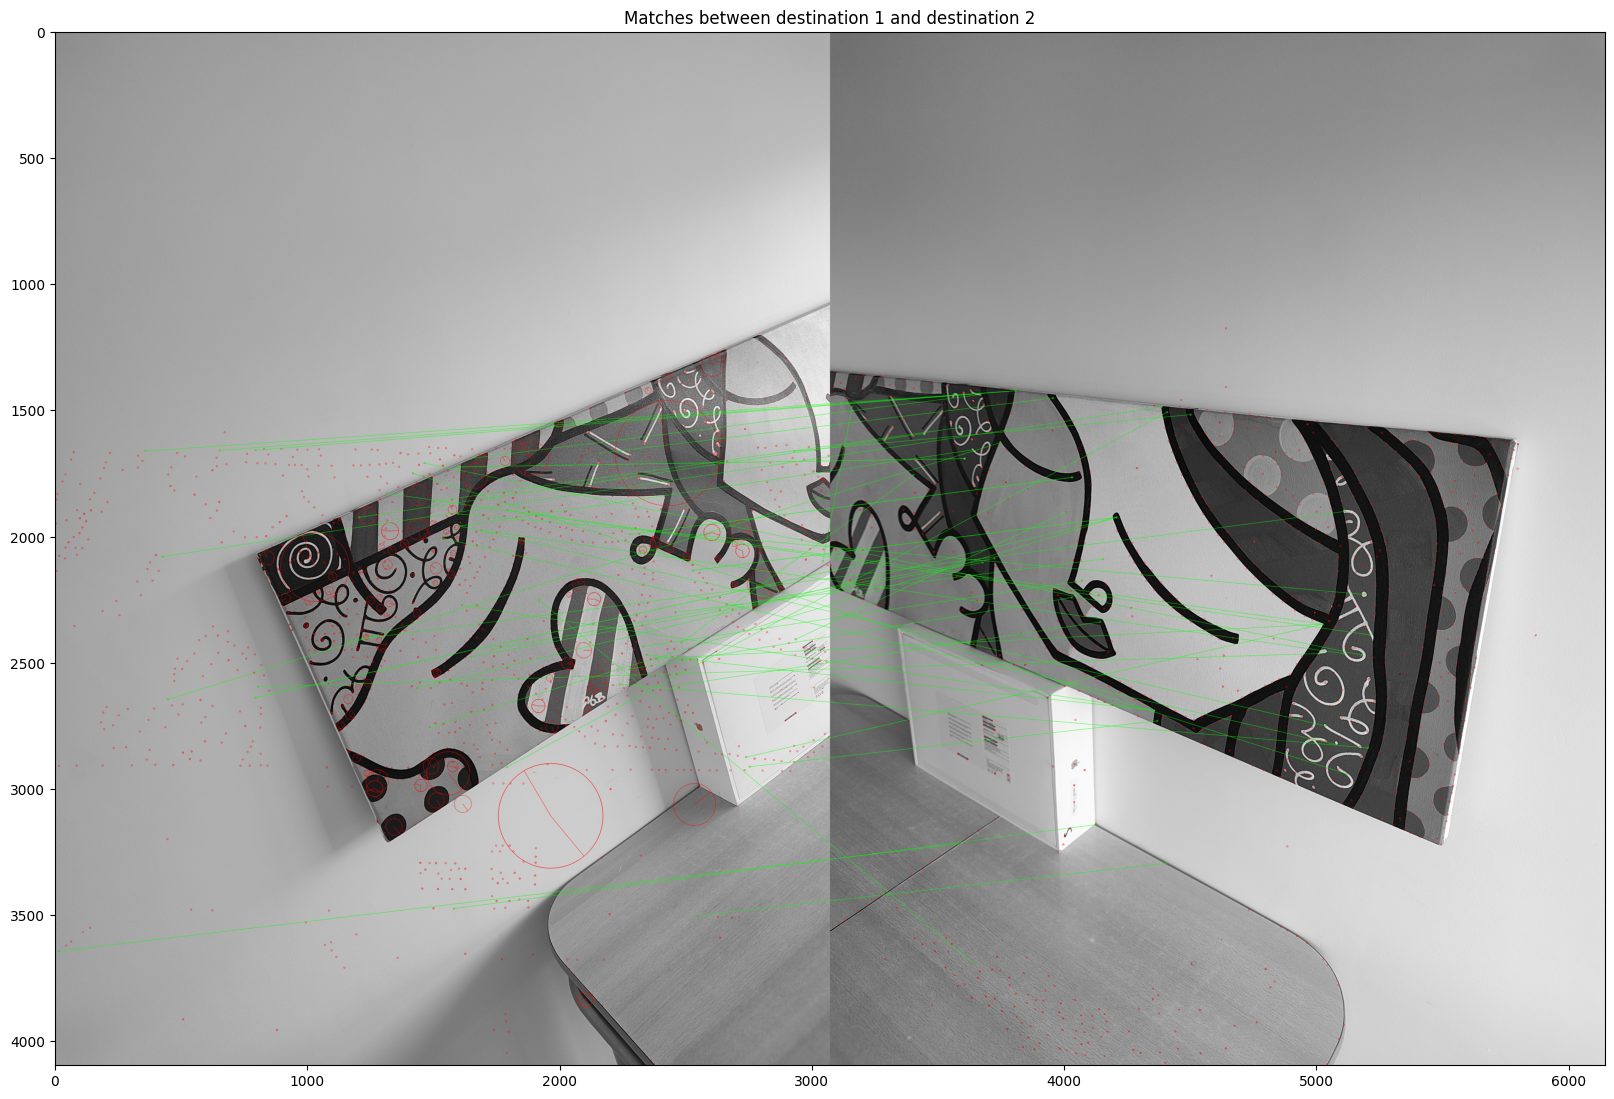

In [51]:
# Draw only good matches
draw_params_01 = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask01,
                   flags=cv2.DrawMatchesFlags_DEFAULT)
draw_params_12 = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask12,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

img_matches01 = cv2.drawMatchesKnn(anms_kp_cuadro0, anms_kp0, cuadro1, anms_kp1, matches01, None, **draw_params_01)
img_matches12 = cv2.drawMatchesKnn(anms_kp_cuadro0, anms_kp1, cuadro2, anms_kp2, matches12, None, **draw_params_12)

plt.figure(figsize=(20, 16))
plt.imshow(img_matches01)
plt.title("Matches between source and destination 1")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(img_matches12)
plt.title("Matches between destination 1 and destination 2")
plt.show()

In [52]:
# Now we want to find the homography matrix that maps the source image to the destination image
good_matches01 = get_good_matches(matches01, matchesMask01)
good_matches12 = get_good_matches(matches12, matchesMask12)

print('Number of good matches:', len(good_matches01)) # remember: minimum matches needed to find the homography matrix is 4 (each match provides 2 equations)
print('Number of good matches:', len(good_matches12))

Number of good matches: 71
Number of good matches: 51


In [53]:
# Find homographies
H01, inliers01 = ransac_homography(kp0, kp1, good_matches01)
H12, inliers12 = ransac_homography(kp1, kp2, good_matches12)

print(f'Number of inliers: {len(inliers01)}')
print(f'Number of inliers: {len(inliers12)}')

Number of inliers: 24
Number of inliers: 7


In [54]:
# Warp images
result01 = warp_images(cuadro0, cuadro1, H01)
H21 = np.linalg.inv(H12)  
result21 = warp_images(cuadro2, cuadro1, H21)


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

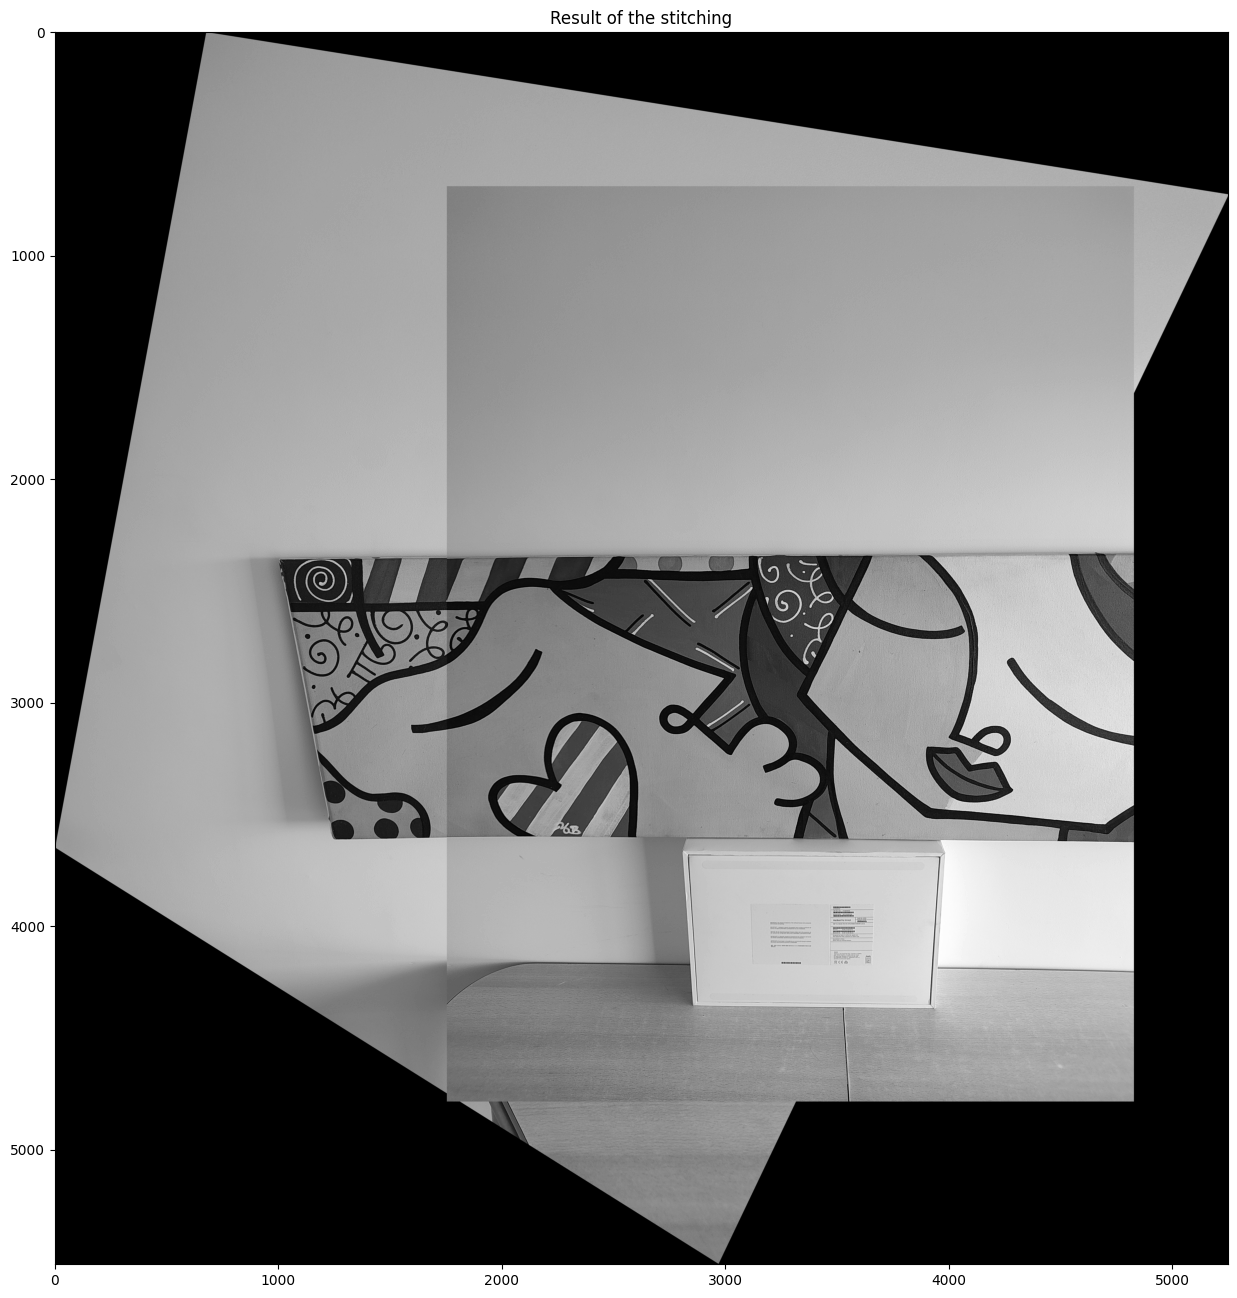

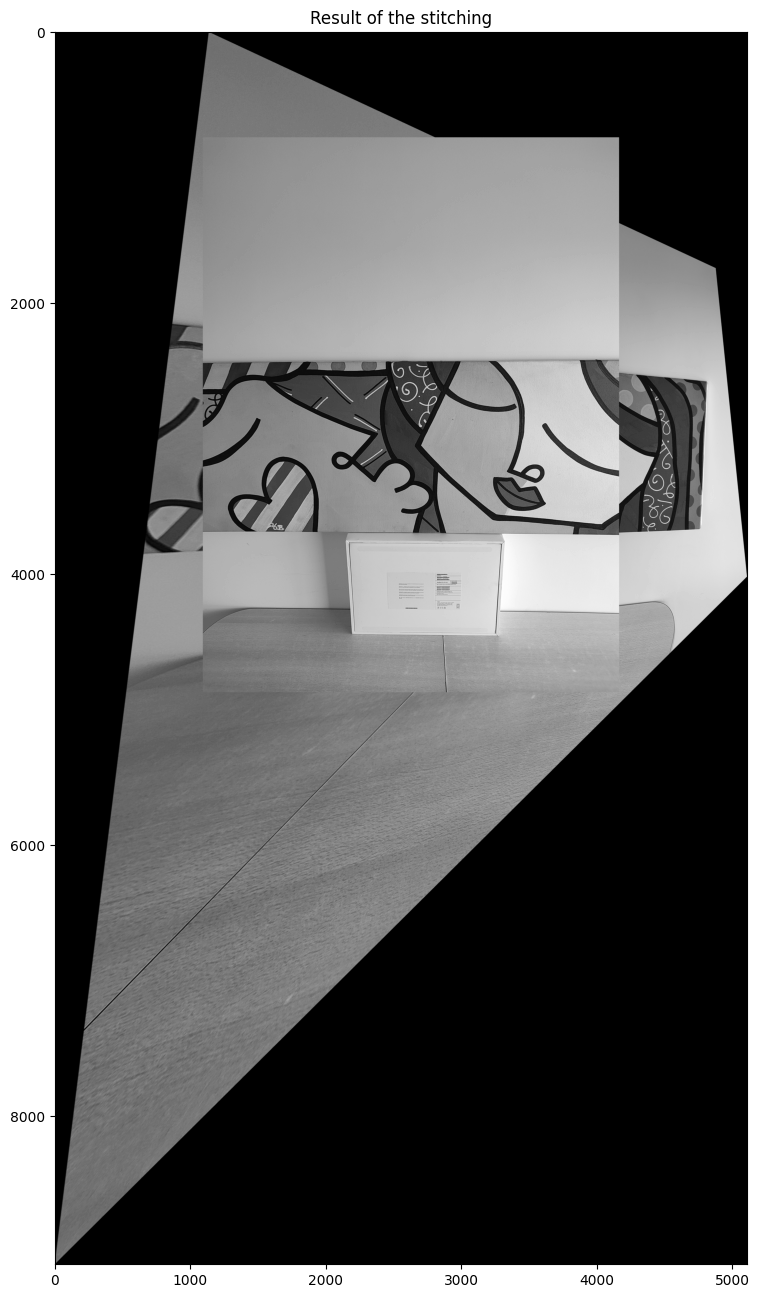

In [43]:
# Display result 
plt.figure(figsize=(20, 16))
plt.imshow(result01, cmap='gray')
plt.title("Result of the stitching")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(result21, cmap='gray')
plt.title("Result of the stitching")
plt.show()

In [44]:
kp01, des01 = algo.detectAndCompute(result01, None)
kp21, des21 = algo.detectAndCompute(result21, None)

matches, matchesMask = match_descriptors(des01, des21)

good_matches = get_good_matches(matches, matchesMask)
print('Number of good matches:', len(good_matches)) 

H, inliers = ransac_homography(kp01, kp21, good_matches)
print(f'Number of inliers: {len(inliers)}')
result = warp_images(result01, result21, H)

Number of good matches: 15091


KeyboardInterrupt: 

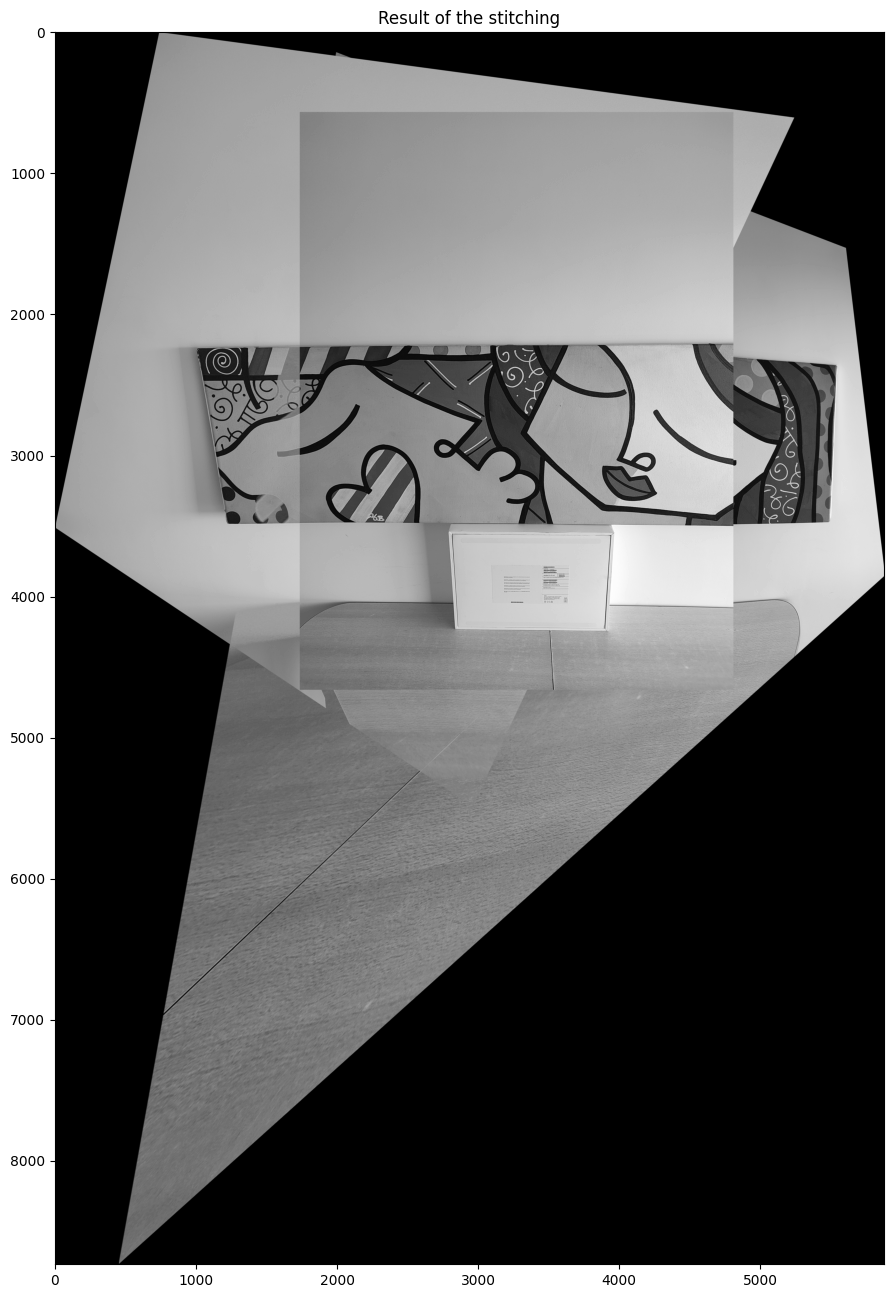

In [32]:
plt.figure(figsize=(20, 16))
plt.imshow(result, cmap='gray')
plt.title("Result of the stitching")
plt.show()